In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Expects timeseries.py in same folder as nb. 
from fastai.vision import *
from pathlib import Path
import pdb
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import fastai.callbacks.hooks

In [3]:
path = untar_data(URLs.PETS)
path = path/"images"

In [4]:
class SidekickAlexNet(nn.Module):
    def __init__(self, num_classes=1000,pretrained=True):
        super().__init__()
        
        self.hero = create_body(models.alexnet,pretrained=pretrained)
        ml = [f for i,f in enumerate(next(self.hero.children()).children()) if i in [2,5,7,9,12]]
        self.hooks = fastai.callbacks.Hooks(ml,lambda m,i,o: o,detach=False)
        
        self.features = nn.ModuleList(
            [nn.Sequential(nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2)),
            nn.Sequential(nn.Conv2d(64*2, 192, kernel_size=5, padding=2),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2)),
            nn.Sequential(nn.Conv2d(192*2, 384, kernel_size=3, padding=1),nn.ReLU(inplace=True)),
            nn.Sequential(nn.Conv2d(384*2, 256, kernel_size=3, padding=1),nn.ReLU(inplace=True)),
            nn.Sequential(nn.Conv2d(256*2, 256, kernel_size=3, padding=1),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2))])
        
        self.classifier = create_head(256*2*2,num_classes)

    def forward(self, x):
        bs = x.shape[0]
        pt = self.hero(x)
        
        x = self.features[0](x)
        for f, a in zip(self.features[1:],self.hooks.stored):
            x = f(torch.cat([x,a],dim=1))
            
        x = torch.cat([x,pt],dim=1)    
        x = self.classifier(x)
        return x


In [5]:
def doRun():
    out = []
    data = ImageDataBunch.from_name_re(path,list(path.glob("*.jpg")),r'/([^/]+)_\d+.jpg$',size=224,bs=64)
    data = data.normalize(imagenet_stats)
    
    learn = create_cnn(data,models.alexnet,metrics=accuracy)
    learn.freeze()
    learn.fit_one_cycle(10,1e-3)
    out.append(max([m[0].item() for m in learn.recorder.metrics]))
    learn.unfreeze()
    learn.fit_one_cycle(10,1e-5)
    out.append(max([m[0].item() for m in learn.recorder.metrics]))
    
    learnSK = Learner(data,SidekickAlexNet(data.train_ds.c),metrics=[accuracy])
    learnSK.split([learnSK.model.hero,learnSK.model.features[0],learnSK.model.classifier])
    learnSK.freeze_to(1)
    learnSK.fit_one_cycle(20,1e-3)
    out.append(max([m[0].item() for m in learnSK.recorder.metrics]))
    
    return out

In [6]:
results = [doRun() for _ in progress_bar(range(10))]

epoch,train_loss,valid_loss,accuracy
1,3.814941,2.946226,0.217862
2,2.426778,1.405001,0.664411
3,1.452596,0.885443,0.752368
4,1.011471,0.724164,0.788904
5,0.840480,0.644471,0.799729
6,0.695960,0.606871,0.810555
7,0.628197,0.588578,0.809878
8,0.564305,0.576030,0.820027
9,0.547868,0.570005,0.816644
10,0.532981,0.568230,0.818674


epoch,train_loss,valid_loss,accuracy
1,0.524369,0.568436,0.822057
2,0.519501,0.561365,0.820704
3,0.509598,0.554155,0.828146
4,0.489952,0.551255,0.822057
5,0.471760,0.541362,0.828146
6,0.462124,0.541532,0.826116
7,0.441700,0.538263,0.826116
8,0.431968,0.537940,0.828823
9,0.428592,0.538633,0.830853
10,0.428057,0.533773,0.831529


epoch,train_loss,valid_loss,accuracy
1,3.096046,2.623873,0.497294
2,2.165029,1.624560,0.679973
3,1.330619,1.001128,0.772666
4,0.825963,0.779945,0.792287
5,0.591282,0.658751,0.793640
6,0.406783,0.627420,0.802436
7,0.257475,0.612568,0.803112
8,0.183278,0.671941,0.799729
9,0.141918,0.613913,0.809878
10,0.081659,0.568123,0.845061


epoch,train_loss,valid_loss,accuracy
1,3.780023,2.908284,0.259811
2,2.463227,1.415213,0.681326
3,1.462177,0.897246,0.759811
4,1.013074,0.728971,0.787551
5,0.813033,0.661562,0.801083
6,0.716667,0.616767,0.809202
7,0.640255,0.605049,0.811231
8,0.574328,0.588229,0.820027
9,0.538261,0.586924,0.819350
10,0.528788,0.585262,0.821380


epoch,train_loss,valid_loss,accuracy
1,0.530411,0.579141,0.822733
2,0.526910,0.576366,0.826793
3,0.506565,0.568545,0.830853
4,0.486020,0.566596,0.822733
5,0.466467,0.563425,0.830176
6,0.447161,0.561459,0.834912
7,0.436695,0.557754,0.834912
8,0.426254,0.554085,0.836942
9,0.422579,0.556139,0.838295
10,0.414059,0.557723,0.836265


epoch,train_loss,valid_loss,accuracy
1,3.110068,2.636014,0.466170
2,2.173314,1.623305,0.677943
3,1.340136,0.997867,0.780108
4,0.832239,0.782767,0.779432
5,0.574951,0.821563,0.744249
6,0.412556,0.730492,0.784844
7,0.281507,0.681617,0.798376
8,0.182042,0.689019,0.809878
9,0.127712,0.678145,0.803789
10,0.085606,0.668742,0.819350


epoch,train_loss,valid_loss,accuracy
1,3.748104,2.893104,0.256428
2,2.418823,1.465787,0.634641
3,1.464496,0.930290,0.746955
4,1.018279,0.749267,0.784844
5,0.814462,0.668330,0.809878
6,0.697871,0.626486,0.816644
7,0.619546,0.603720,0.822733
8,0.576442,0.593315,0.828146
9,0.544044,0.589122,0.825440
10,0.541247,0.588112,0.826116


epoch,train_loss,valid_loss,accuracy
1,0.525231,0.587005,0.830853
2,0.522614,0.572721,0.830853
3,0.508334,0.564903,0.834235
4,0.482569,0.559538,0.831529
5,0.462130,0.549817,0.843031
6,0.452647,0.545317,0.836265
7,0.441393,0.543226,0.838295
8,0.442696,0.542158,0.841678
9,0.424302,0.543120,0.838972
10,0.427405,0.542523,0.841001


epoch,train_loss,valid_loss,accuracy
1,3.087260,2.635013,0.466847
2,2.156912,1.618646,0.687415
3,1.333091,1.023635,0.748309
4,0.830636,0.785438,0.791610
5,0.564253,0.696617,0.798376
6,0.438979,0.655154,0.793640
7,0.310118,0.638077,0.803789
8,0.188712,0.619183,0.815291
9,0.125548,0.600955,0.830176
10,0.091040,0.638880,0.820027


epoch,train_loss,valid_loss,accuracy
1,3.798728,2.974255,0.208390
2,2.465230,1.429935,0.655616
3,1.460909,0.892968,0.765900
4,1.001835,0.706334,0.799729
5,0.821519,0.644654,0.814614
6,0.706668,0.619745,0.814614
7,0.635678,0.593178,0.817997
8,0.583084,0.586173,0.806495
9,0.551502,0.582121,0.812585
10,0.543741,0.584092,0.809202


epoch,train_loss,valid_loss,accuracy
1,0.528176,0.581178,0.815291
2,0.519483,0.570481,0.818674
3,0.505768,0.567724,0.820027
4,0.485358,0.564816,0.821380
5,0.461989,0.559433,0.825440
6,0.451474,0.558134,0.820704
7,0.435170,0.556692,0.822057
8,0.417306,0.553375,0.822733
9,0.439501,0.553841,0.824763
10,0.424425,0.555112,0.827470


epoch,train_loss,valid_loss,accuracy
1,3.108355,2.636471,0.440460
2,2.196859,1.647279,0.695535
3,1.348741,1.031140,0.758457
4,0.854814,0.926553,0.748985
5,0.583620,0.800521,0.753045
6,0.405619,0.654577,0.800406
7,0.257872,0.677578,0.782138
8,0.173376,0.631713,0.792287
9,0.129551,0.648987,0.798376
10,0.088851,0.571689,0.827470


epoch,train_loss,valid_loss,accuracy
1,3.815482,2.941981,0.238836
2,2.454386,1.416542,0.663058
3,1.477621,0.872763,0.762517
4,1.016374,0.697731,0.804465
5,0.827543,0.623669,0.816644
6,0.708622,0.578678,0.828146
7,0.640651,0.553023,0.836265
8,0.583048,0.544344,0.830176
9,0.561021,0.536969,0.838972
10,0.555357,0.537454,0.839648


epoch,train_loss,valid_loss,accuracy
1,0.542988,0.533681,0.837618
2,0.549847,0.524361,0.843708
3,0.519638,0.513384,0.846414
4,0.494414,0.508585,0.843708
5,0.473998,0.506475,0.843031
6,0.469269,0.504081,0.848444
7,0.440012,0.501827,0.843708
8,0.445221,0.497706,0.847767
9,0.432978,0.499349,0.849120
10,0.427401,0.499313,0.847767


epoch,train_loss,valid_loss,accuracy
1,3.094623,2.648078,0.478349
2,2.175784,1.612711,0.702977
3,1.344233,0.987339,0.774019
4,0.857364,0.738113,0.801759
5,0.574353,0.662782,0.791610
6,0.410594,0.574033,0.813261
7,0.273425,0.598611,0.817321
8,0.171861,0.555413,0.828823
9,0.113950,0.633611,0.808525
10,0.099937,0.603660,0.817997


epoch,train_loss,valid_loss,accuracy
1,3.763052,2.927192,0.228687
2,2.413817,1.426714,0.640731
3,1.462987,0.901492,0.757104
4,1.026629,0.737737,0.781461
5,0.829432,0.666167,0.801083
6,0.721219,0.617148,0.806495
7,0.645404,0.593334,0.820704
8,0.591384,0.579694,0.827470
9,0.543228,0.583691,0.824763
10,0.546404,0.578444,0.822057


epoch,train_loss,valid_loss,accuracy
1,0.556943,0.575284,0.823410
2,0.522420,0.564637,0.830853
3,0.523743,0.558321,0.830176
4,0.513350,0.546952,0.836265
5,0.480299,0.544787,0.838972
6,0.457613,0.539859,0.834235
7,0.444469,0.541206,0.829499
8,0.425580,0.536784,0.834235
9,0.436487,0.535902,0.838295
10,0.435783,0.534117,0.838295


epoch,train_loss,valid_loss,accuracy
1,3.078030,2.607627,0.461434
2,2.146748,1.602772,0.686062
3,1.341887,0.968428,0.780785
4,0.838189,0.850141,0.753721
5,0.577329,0.848362,0.742896
6,0.411837,0.626502,0.800406
7,0.283770,0.568067,0.819350
8,0.176006,0.633768,0.818674
9,0.117731,0.619015,0.818674
10,0.076184,0.542481,0.828823


epoch,train_loss,valid_loss,accuracy
1,3.823368,2.994618,0.221245
2,2.452140,1.442211,0.646820
3,1.459525,0.916001,0.746279
4,1.019574,0.750286,0.778078
5,0.810020,0.675657,0.796346
6,0.677267,0.636472,0.806495
7,0.604158,0.617970,0.814614
8,0.566280,0.603828,0.816644
9,0.541526,0.604047,0.817997
10,0.532169,0.602189,0.822057


epoch,train_loss,valid_loss,accuracy
1,0.526254,0.596845,0.820704
2,0.507688,0.589969,0.821380
3,0.503070,0.582509,0.828146
4,0.469367,0.574608,0.829499
5,0.450625,0.567903,0.831529
6,0.441045,0.562904,0.833559
7,0.433514,0.562356,0.836265
8,0.441702,0.563513,0.834912
9,0.413852,0.561863,0.832882
10,0.416047,0.559750,0.834912


epoch,train_loss,valid_loss,accuracy
1,3.094591,2.662552,0.476319
2,2.214719,1.665429,0.697564
3,1.378347,1.034891,0.763870
4,0.860685,0.865306,0.751691
5,0.598150,0.722638,0.779432
6,0.405197,0.680906,0.790257
7,0.273724,0.637392,0.807848
8,0.171026,0.715976,0.786198
9,0.122000,0.620906,0.810555
10,0.075168,0.670583,0.802436


epoch,train_loss,valid_loss,accuracy
1,3.822688,3.020838,0.203654
2,2.491460,1.493517,0.627199
3,1.507777,0.953278,0.725304
4,1.048529,0.774852,0.773342
5,0.834040,0.689331,0.790257
6,0.725445,0.637283,0.805142
7,0.643457,0.609591,0.805142
8,0.584819,0.599416,0.809878
9,0.555102,0.594773,0.815968
10,0.544200,0.593049,0.815968


epoch,train_loss,valid_loss,accuracy
1,0.538545,0.588986,0.813938
2,0.522474,0.579176,0.813938
3,0.524415,0.570554,0.813938
4,0.500012,0.563694,0.817997
5,0.472349,0.557723,0.818674
6,0.461348,0.552253,0.822733
7,0.437450,0.553707,0.821380
8,0.435682,0.549432,0.818674
9,0.430756,0.550371,0.824087
10,0.422244,0.541741,0.824763


epoch,train_loss,valid_loss,accuracy
1,3.088273,2.661331,0.476996
2,2.169757,1.620970,0.707037
3,1.349045,1.014012,0.762517
4,0.842280,0.797988,0.769959
5,0.573584,0.676891,0.784168
6,0.405711,0.645078,0.798376
7,0.281288,0.619960,0.807848
8,0.176608,0.570131,0.828146
9,0.109828,0.616122,0.811231
10,0.076370,0.614148,0.815291


epoch,train_loss,valid_loss,accuracy
1,3.836755,2.945745,0.235453
2,2.439728,1.407845,0.652909
3,1.467900,0.885053,0.756428
4,1.028083,0.718031,0.802436
5,0.821816,0.642538,0.806495
6,0.696303,0.609140,0.813938
7,0.627095,0.585446,0.823410
8,0.593011,0.567759,0.825440
9,0.549785,0.565436,0.827470
10,0.552268,0.560313,0.828146


epoch,train_loss,valid_loss,accuracy
1,0.529457,0.560785,0.826793
2,0.517361,0.551438,0.828823
3,0.509917,0.540489,0.830176
4,0.498422,0.536014,0.830176
5,0.466323,0.531843,0.831529
6,0.463951,0.530368,0.837618
7,0.446659,0.530320,0.836942
8,0.432091,0.528913,0.830853
9,0.420818,0.528948,0.834912
10,0.421830,0.529468,0.830176


epoch,train_loss,valid_loss,accuracy
1,3.101637,2.635469,0.476996
2,2.159389,1.581619,0.728011
3,1.340203,1.021806,0.770636
4,0.851015,0.752886,0.796346
5,0.564889,0.647219,0.812585
6,0.402493,0.683159,0.781461
7,0.277551,0.612032,0.792287
8,0.181346,0.586884,0.807848
9,0.108800,0.593072,0.815968
10,0.074402,0.623505,0.811908


epoch,train_loss,valid_loss,accuracy
1,3.772084,2.917673,0.242896
2,2.411573,1.402173,0.656969
3,1.455411,0.890696,0.751691
4,1.044577,0.711556,0.789581
5,0.824243,0.634118,0.811908
6,0.702756,0.600246,0.813261
7,0.615903,0.579695,0.819350
8,0.573610,0.563112,0.824087
9,0.562705,0.559622,0.824763
10,0.533780,0.559045,0.823410


epoch,train_loss,valid_loss,accuracy
1,0.520160,0.555981,0.826793
2,0.534781,0.544166,0.834235
3,0.512798,0.538760,0.832882
4,0.485347,0.529594,0.838295
5,0.476182,0.524426,0.838295
6,0.460172,0.521678,0.836265
7,0.453786,0.520666,0.843031
8,0.428736,0.518212,0.841001
9,0.429073,0.520369,0.839648
10,0.426730,0.522957,0.837618


epoch,train_loss,valid_loss,accuracy
1,3.075829,2.600394,0.463464
2,2.140165,1.599130,0.698241
3,1.339658,0.982866,0.772666
4,0.854795,0.775272,0.774019
5,0.592445,0.814330,0.752368
6,0.457307,0.703800,0.774696
7,0.327253,0.653043,0.807848
8,0.216034,0.595040,0.816644
9,0.142541,0.649321,0.801083
10,0.097316,0.574394,0.828146


In [8]:
df = pd.DataFrame(results,columns=["Head","Fine Tune","Sidekick"])

In [9]:
df

,Head,Fine Tune,Sidekick
0,0.820027,0.831529,0.859946
1,0.821380,0.838295,0.836265
2,0.828146,0.843031,0.845737
3,0.817997,0.827470,0.846414
4,0.839648,0.849120,0.861299
5,0.827470,0.838972,0.851150
6,0.822057,0.836265,0.845061
7,0.815968,0.824763,0.843708
8,0.828146,0.837618,0.840325
9,0.824763,0.843031,0.850474


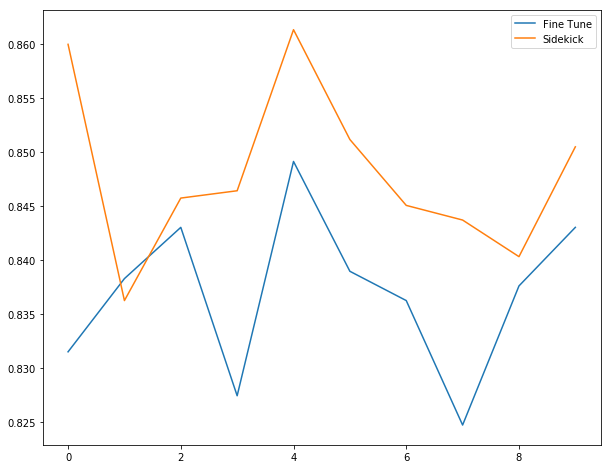

In [11]:
df[["Fine Tune","Sidekick"]].plot(figsize=(10,8))